## Problem Statement

### Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

 

### Understanding and Defining Churn
There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

 

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

 

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

 

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.

 

This project is based on the Indian and Southeast Asian market.

 

### Definitions of Churn
There are various ways to define churn, such as:

#### Revenue-based churn: 
Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

 

The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.

 

#### Usage-based churn:
Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

 

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

 

In this project, you will use the usage-based definition to define churn.

 

#### High-value Churn:
In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

 

In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

 

### Understanding the Business Objective and the Data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

 

### Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In [219]:
#Importing Libraries
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
#Ignore warnings
warnings.filterwarnings('ignore')

#Importing sklearn libraries
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import gc
import os

In [220]:
#Data loading

df = pd.read_csv('telecom_churn_data.csv')
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [221]:
df.shape

(99999, 226)

In [222]:
#Checking the columns

df.columns.tolist()


['mobile_number',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 's

In [223]:
#Checking the data dictionary to understand the data
data_dict = pd.read_excel('Data+Dictionary-+Telecom+Churn+Case+Study.xlsx')
data_dict

,Acronyms,Descriptions
0,MOBILE_NUMBER,Customer phone number
1,CIRCLE_ID,Telecom circle area to which the customer belo...
2,LOC,Local calls - within same telecom circle
3,STD,STD calls - outside the calling circle
4,IC,Incoming calls
5,OG,Outgoing calls
6,T2T,"Operator T to T, i.e. within same operator (mo..."
7,T2M,Operator T to other operator mobile
8,T2O,Operator T to other operator fixed line
9,T2F,Operator T to fixed lines of T


We need to target the columns having recharge amount or recharge data to find out the potential customers who could churn. Lets check the missing values on those columns having the keyword recharge. 

### EDA, Data Cleaning and Preparation

In [224]:
#Putting the recharge columns together
rech_cols =  df.columns[df.columns.str.contains('rech_amt|rech_data')]

In [225]:
rech_cols

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')

In [226]:
#Checking missing values in the rech_cols

# missing values check for recharge amount
100*df.loc[:,rech_cols].isnull().sum()/len(df)

total_rech_amt_6             0.000000
total_rech_amt_7             0.000000
total_rech_amt_8             0.000000
total_rech_amt_9             0.000000
max_rech_amt_6               0.000000
max_rech_amt_7               0.000000
max_rech_amt_8               0.000000
max_rech_amt_9               0.000000
date_of_last_rech_data_6    74.846748
date_of_last_rech_data_7    74.428744
date_of_last_rech_data_8    73.660737
date_of_last_rech_data_9    74.077741
total_rech_data_6           74.846748
total_rech_data_7           74.428744
total_rech_data_8           73.660737
total_rech_data_9           74.077741
max_rech_data_6             74.846748
max_rech_data_7             74.428744
max_rech_data_8             73.660737
max_rech_data_9             74.077741
av_rech_amt_data_6          74.846748
av_rech_amt_data_7          74.428744
av_rech_amt_data_8          73.660737
av_rech_amt_data_9          74.077741
dtype: float64

As we can see 75% values for max recharge data, average recharge amount & total recharge date & date of data recharge are having null values. Lets look how we can impute the values.

First lets check the distribution of the recharge columns. Then we can check the options of imputing.

In [227]:
#CHecking distribution of column 6

rech_amt_col_6 = df.columns[df.columns.str.contains('rech_amt_6|rech_data_6|rech_amt_data_6')]

df.loc[:,rech_amt_col_6].describe()

,total_rech_amt_6,max_rech_amt_6,total_rech_data_6,max_rech_data_6,av_rech_amt_data_6
count,99999.000000,99999.000000,25153.000000,25153.000000,25153.000000
mean,327.514615,104.637486,2.463802,126.393392,192.600982
std,398.019701,120.614894,2.789128,108.477235,192.646318
min,0.000000,0.000000,1.000000,1.000000,1.000000
25%,109.000000,30.000000,1.000000,25.000000,82.000000
50%,230.000000,110.000000,1.000000,145.000000,154.000000
75%,437.500000,120.000000,3.000000,177.000000,252.000000
max,35190.000000,4010.000000,61.000000,1555.000000,7546.000000


In [228]:
#check if any values where total_rech_data is NA and value is present for av_rech_amt_data & vice versa
#Also check how many av_rech_amt_data_6 is NA
invlid_data_6 = df['av_rech_amt_data_6'] == np.nan
invlid_data_7 = df['av_rech_amt_data_7'] == np.nan
invlid_data_8 = df['av_rech_amt_data_8'] == np.nan

# check if any value is present for these rows for total_rech_data
print(df.loc[invlid_data_6,'total_rech_data_6'].sum())
print(df.loc[invlid_data_7,'total_rech_data_7'].sum())
print(df.loc[invlid_data_8,'total_rech_data_8'].sum())

# check how many total_rech_data_6 is NA
is_invlid_data_6 = df['total_rech_data_6'] == np.nan 
is_invlid_data_7 = df['total_rech_data_7'] == np.nan 
is_invlid_data_8 = df['total_rech_data_8'] == np.nan 

# check if any value is present for these rows for av_rech_amt_data_6
print(df.loc[is_invlid_data_6,'av_rech_amt_data_6'].sum())
print(df.loc[is_invlid_data_7,'av_rech_amt_data_7'].sum())
print(df.loc[is_invlid_data_8,'av_rech_amt_data_8'].sum())

0.0
0.0
0.0
0.0
0.0
0.0


In [229]:
#We could see in previous step values are consistent with each other, also as minimum value is 1 we can impute the NA values by 0 meaning 
#there was no recharge done by the customer.
df.loc[:,['total_rech_data_6','total_rech_data_7','total_rech_data_8']]= \
df.loc[:,['total_rech_data_6','total_rech_data_7','total_rech_data_8']].replace(np.NaN,0)
df.loc[:,['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8']]= \
df.loc[:,['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8']].replace(np.NaN,0)

In [230]:
#Add a new derived variable total recharge amount for data: total_rech_amt_data
df['total_rech_amt_data_6'] = df.av_rech_amt_data_6*df.total_rech_data_6
df['total_rech_amt_data_7'] = df.av_rech_amt_data_7*df.total_rech_data_7
df['total_rech_amt_data_8'] = df.av_rech_amt_data_8*df.total_rech_data_8

Lets define total average recharge amount for good phase since average of total recharge amount & total recharge amount for data for months 6 and 7 (good phase months).

In [231]:
df['total_avg_rech_amnt_good_ph'] = (df.total_rech_amt_6 +df.total_rech_amt_data_6 \
                                               + df.total_rech_amt_7+df.total_rech_amt_data_7)/4

We are defining High Value Customer who have total average recharge amount for good phase greater than 70th percentile value here.

In [232]:
#Lets create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value = df.total_avg_rech_amnt_good_ph >= df.total_avg_rech_amnt_good_ph.quantile(0.7)

In [233]:
#subset out the High Value customers
df = df.loc[high_value,:]

#check count of remain records
len(df.loc[high_value,:])

30001

As we can see above we are left with 30001 rows. We will consider these rows for further analysis.

#### Labeling churned customers

In [234]:
#label the churned customers
#defining new column as "churn" with value as '1' if the customer has churned else '0'.
#Initially set all the values as 0
df['churn']= 0

In [235]:
#total_ic_mou_9, total_ic_mou_9, vol_2g_mb_9 and vol_3g_mb_9 columns will be used to find the churned customers in the 9th month 
#Check if any NA/Null values are present
month_9 = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']
100*df.loc[:,month_9].isnull().sum()/len(df)

total_ic_mou_9    0.0
total_og_mou_9    0.0
vol_2g_mb_9       0.0
vol_3g_mb_9       0.0
dtype: float64

In [236]:
#define churned_cust boolean flag for customers where above values are zero
churned_cust = (df.total_ic_mou_9 == 0) & (df.total_og_mou_9 == 0) & (df.vol_2g_mb_9 ==0)& \
(df.vol_3g_mb_9 ==0)

print(churned_cust.head())

0      True
7      True
8     False
21    False
23    False
dtype: bool


In [237]:
#let's set all such rows fulfilling churned_cust condition as 1
df.loc[churned_cust,'churn']=1

#Now check what's the % of churned customers
100*df.churn.sum()/len(churned_cust)

8.136395453484884

We can see that approximately 8% customers have churned.

In [238]:
#Lets put all 9th month columns in one variable and then drop them from df
month9_cols =  df.columns[df.columns.str.contains('_9')]


In [239]:
df.drop(month9_cols,axis=1,inplace=True)

In [240]:
#Checking the null values in df after dropping 9th month columns

100*df.isnull().sum()/len(df.index)

mobile_number                   0.000000
circle_id                       0.000000
loc_og_t2o_mou                  0.746642
std_og_t2o_mou                  0.746642
loc_ic_t2o_mou                  0.746642
last_date_of_month_6            0.000000
last_date_of_month_7            0.089997
last_date_of_month_8            0.549982
arpu_6                          0.000000
arpu_7                          0.000000
arpu_8                          0.000000
onnet_mou_6                     1.816606
onnet_mou_7                     1.789940
onnet_mou_8                     3.913203
offnet_mou_6                    1.816606
offnet_mou_7                    1.789940
offnet_mou_8                    3.913203
roam_ic_mou_6                   1.816606
roam_ic_mou_7                   1.789940
roam_ic_mou_8                   3.913203
roam_og_mou_6                   1.816606
roam_og_mou_7                   1.789940
roam_og_mou_8                   3.913203
loc_og_t2t_mou_6                1.816606
loc_og_t2t_mou_7

Lets create a function to analyze the features across June,July and August

In [241]:
#Function to create a table to analyze mean and std deviation of a feature
def analyze_col(start_string):
    plt.rcParams["figure.figsize"] = [20, 10]
    fig = plt.figure()
    print("Churn Statistics (mean and standard deviation):")
    cols = {c: start_string + "_" + str(c) for c in [6,7,8]}
    print(cols)
    data_tab = []
    [data_tab.append({
        "mean_6": df[df["churn"] == churn][cols[6]].mean(),
        "mean_7": df[df["churn"] == churn][cols[7]].mean(),
        "mean_8": df[df["churn"] == churn][cols[8]].mean(),
        "std_6": df[df["churn"] == churn][cols[6]].std(),
        "std_7": df[df["churn"] == churn][cols[7]].std(),
        "std_8": df[df["churn"] == churn][cols[8]].std()
    }) for churn in [0,1]]
    
    #Plotting box plot to analyze the distribution of features across three months
    
    f,axes = plt.subplots(nrows=1, ncols=3)
    sns.boxplot(data=df, y=start_string + "_6", x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[0],color="skyblue")
    sns.boxplot(data=df, y=start_string + "_7",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[1],color="skyblue")
    sns.boxplot(data=df, y=start_string + "_8",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[2],color="skyblue")
    plt.show()
    return pd.DataFrame(data_tab,index={"Non Churned","Churned"}).round(3)

### Analyzing Recharge features 

In [242]:
#Lets pur recharge columns in one variable and then analyze them one by one.

recharge_cols =  df.columns[df.columns.str.contains('rech_amt')]

print(recharge_cols)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'total_rech_amt_data_6', 'total_rech_amt_data_7',
       'total_rech_amt_data_8'],
      dtype='object')


Churn Statistics (mean and standard deviation):
{6: 'total_rech_amt_6', 7: 'total_rech_amt_7', 8: 'total_rech_amt_8'}


<Figure size 1440x720 with 0 Axes>

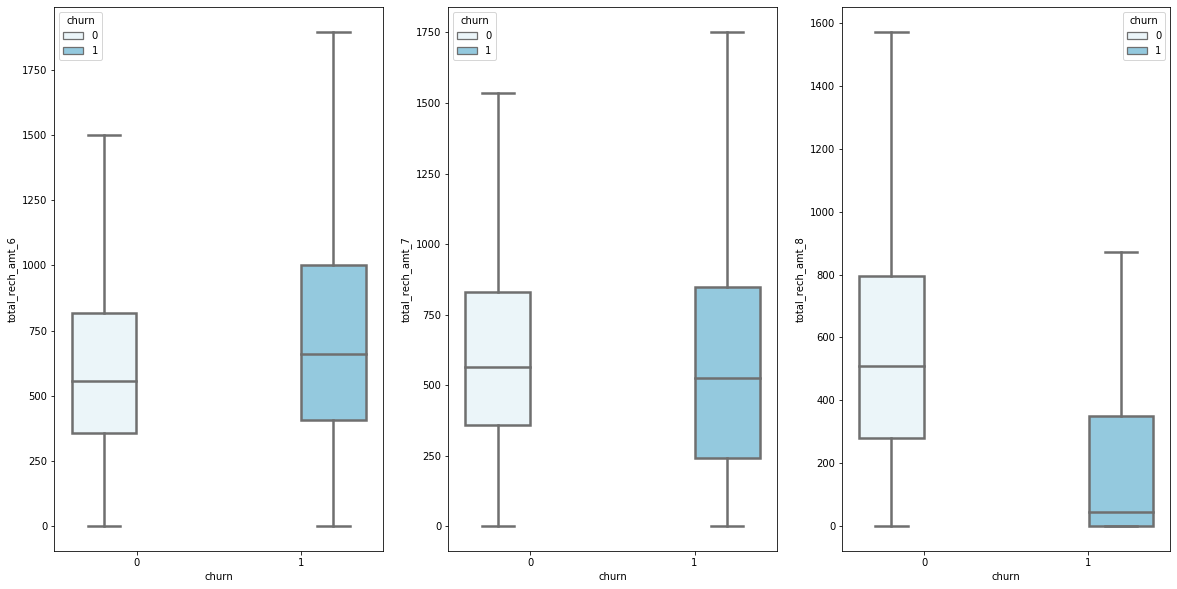

,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,649.575,663.528,613.701,547.703,574.160,614.833
Non Churned,786.707,626.290,253.153,681.562,667.938,452.360


In [243]:
#analyzing total recharge amount:
analyze_col('total_rech_amt')

#### Insight:
- As we can see above the standard deviation is significantly less for the churned customers than the non churned customers.
- For the churned customers the total recharge amount decreases in the 8th month i.e the action phase.  

Churn Statistics (mean and standard deviation):
{6: 'total_rech_amt_data_6', 7: 'total_rech_amt_data_7', 8: 'total_rech_amt_data_8'}


<Figure size 1440x720 with 0 Axes>

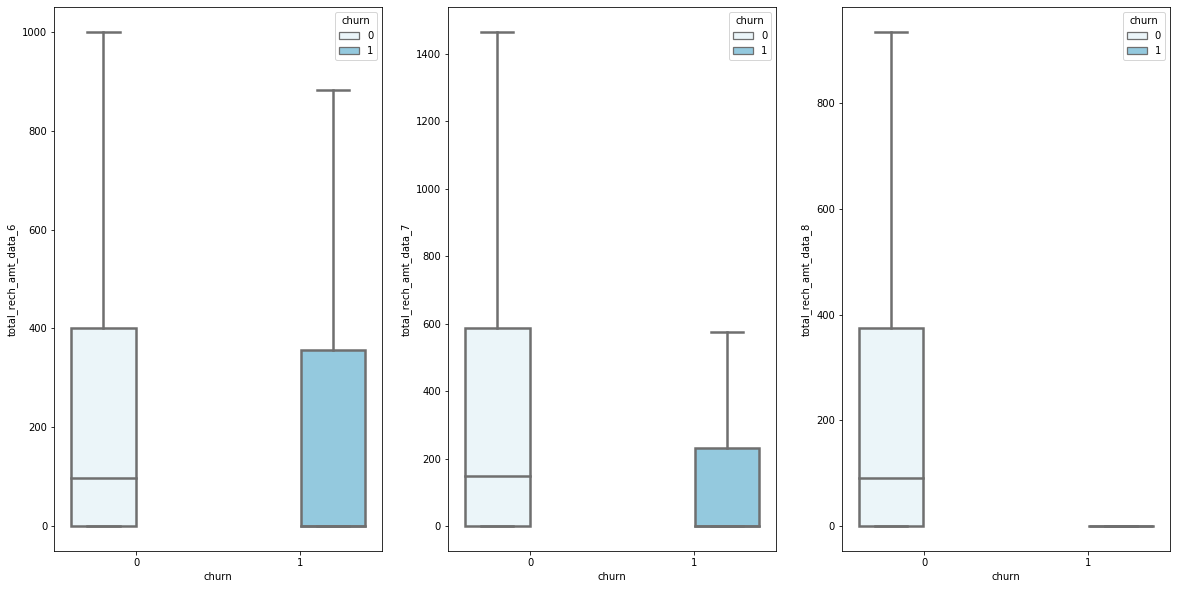

,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,460.077,545.057,496.886,1446.356,1498.871,1683.029
Non Churned,407.229,338.294,83.523,1055.937,1171.760,476.784


In [244]:
#analyzing total data recharge amount:
analyze_col('total_rech_amt_data')

#### Insight:
- As we can see above the standard deviation and mean are significantly less for the churned customers than the non churned customers in the action phase i.e. the 8th month.
- For the churned customers the total recharge amount for data decreases and is almost zero in the 8th month i.e the action phase.  

Churn Statistics (mean and standard deviation):
{6: 'max_rech_amt_6', 7: 'max_rech_amt_7', 8: 'max_rech_amt_8'}


<Figure size 1440x720 with 0 Axes>

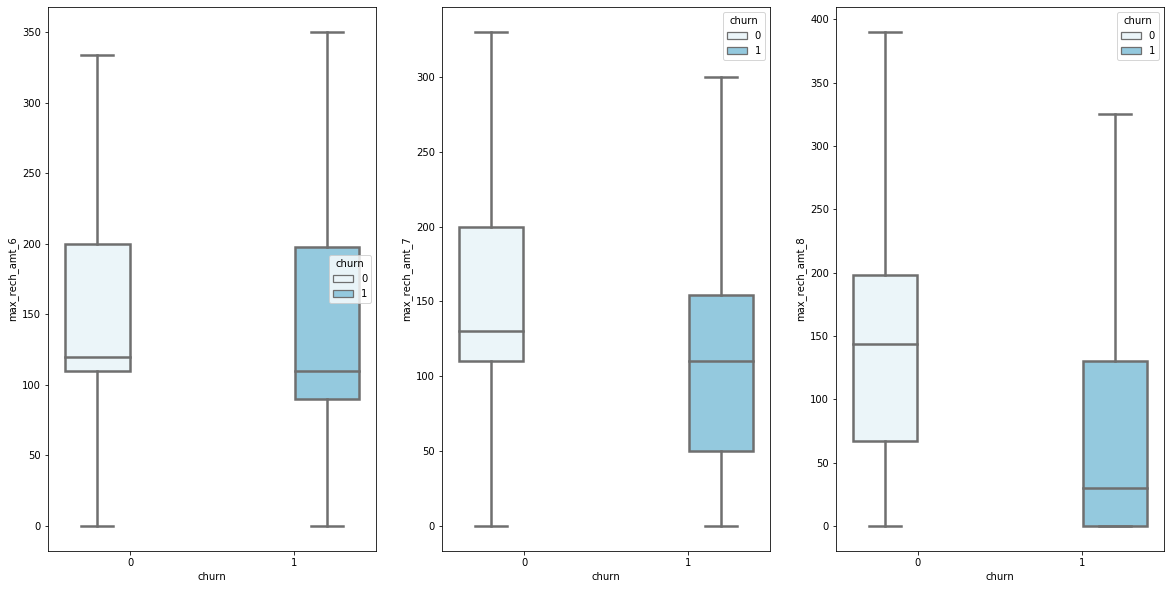

,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,169.049,173.337,166.767,172.005,176.749,171.337
Non Churned,171.942,159.389,85.371,209.116,226.966,176.648


In [245]:
#analyzing maximum recharge amount for data:
analyze_col('max_rech_amt')

#### Insight:
- It is ovious that the maximum recharge amount is also decreasing as the total recharge amount is decreasing.
- As we have already dericed the total recharge amount using average and total recharge data, lets drop those columns.

In [246]:
# dropping av_rech_amt_data and total_rech_data columns
df.drop(['av_rech_amt_data_6','av_rech_amt_data_7'
                   ,'av_rech_amt_data_8','total_rech_data_6','total_rech_data_7','total_rech_data_8'],axis=1,inplace=True)

In [247]:
# Deriving new features
# Total recharge amount for good phase: total_rech_amt_good_ph
# Total recharge amount data for good phase: total_rech_amt_data_good_ph
# Max recharge amount for good phase: max_rech_amt_good_ph

df['total_rech_amt_good_ph'] = (df.total_rech_amt_6 + df.total_rech_amt_7)/2
df['total_rech_amt_data_good_ph'] = (df.total_rech_amt_data_6 + df.total_rech_amt_data_7)/2
df['max_rech_amt_good_ph'] = (df.max_rech_amt_6 + df.max_rech_amt_7)/2

# dropping the original columns
df.drop(['total_rech_amt_6','total_rech_amt_7'
              ,'max_rech_amt_6','max_rech_amt_7','total_rech_amt_data_6','total_rech_amt_data_7'],axis=1,inplace=True)

# drop total_avg_rech_amnt_good_ph as we derived total_rech_amt_data_good_ph 
df.drop('total_avg_rech_amnt_good_ph',axis=1,inplace=True)

In [248]:
#Extracting last day recharge amount
last_day_rech_amt = df.columns[df.columns.str.contains('day')]

Churn Statistics (mean and standard deviation):
{6: 'last_day_rch_amt_6', 7: 'last_day_rch_amt_7', 8: 'last_day_rch_amt_8'}


<Figure size 1440x720 with 0 Axes>

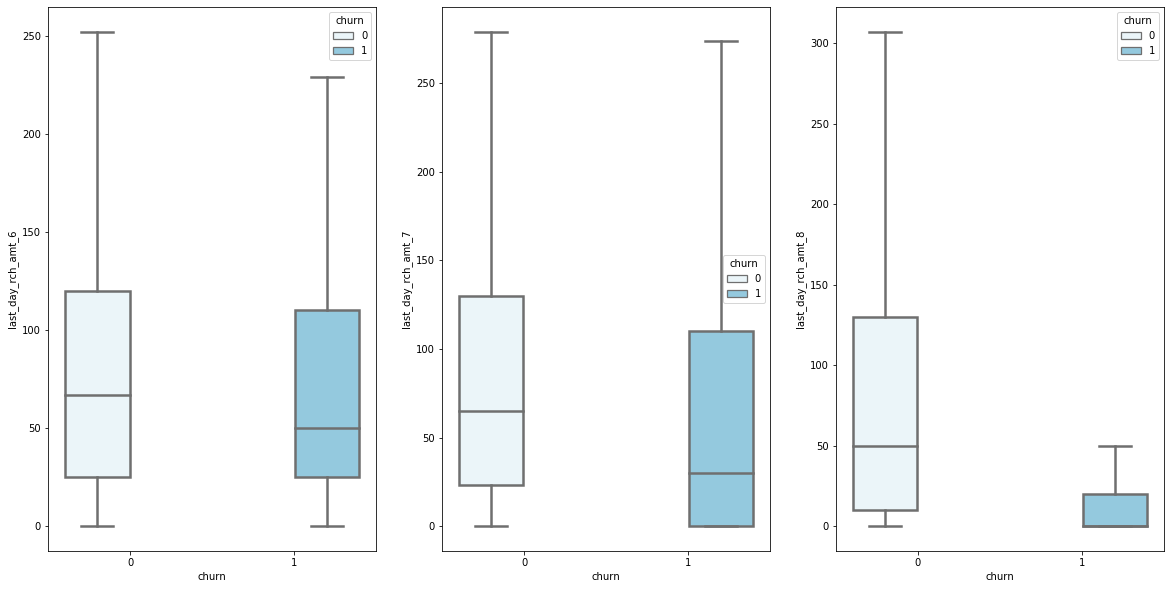

,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,100.587,102.276,97.417,140.808,139.566,145.528
Non Churned,104.356,78.684,35.680,173.407,153.831,128.249


In [249]:
#Analyzing last_day_rech_amt

analyze_col('last_day_rch_amt')

For churned customers there is a significant drop in the last month recharge amount.

In [250]:
#Deriving new feature last day rech amt in good phase by taking avh of 6th and 7th month data.
df['last_day_rch_amt_good_ph'] = (df.last_day_rch_amt_6 + df.last_day_rch_amt_7)/2

# drop the original column
df.drop(['last_day_rch_amt_6','last_day_rch_amt_7'],axis=1,inplace=True)

In [251]:
#Check other recharge related variables:
oth_rch = df.columns[df.columns.str.contains('rech_num|max_rech_data',regex=True)]

#checking the percentage of missing values
100*df.loc[:,oth_rch].isnull().sum()/len(df)

total_rech_num_6     0.000000
total_rech_num_7     0.000000
total_rech_num_8     0.000000
max_rech_data_6     44.148528
max_rech_data_7     43.145228
max_rech_data_8     46.825106
dtype: float64

In [252]:
#Distribution of the oth_rch cols

df.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,16756.000000,17057.000000,15953.000000
mean,139.798580,140.431143,136.329217
std,118.851784,120.247247,119.531924
min,1.000000,1.000000,1.000000
25%,25.000000,25.000000,25.000000
50%,152.000000,152.000000,152.000000
75%,198.000000,198.000000,198.000000
max,1555.000000,1555.000000,1555.000000


The minimum value is 1 and the max is 1555 for all three, this implies the missing values means no recharge was done for data, we can impute the missing values by 0. 

In [253]:
#Imputing nan with zero max_rech_data.

df.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']] \
= df.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)


In [254]:
# deriving new column: max_rech_data_good_ph
df['max_rech_data_good_ph'] = (df.max_rech_data_6 + df.max_rech_data_7)/2

# dropping the original columns
df.drop(['max_rech_data_6','max_rech_data_7'],axis=1,inplace=True)

In [255]:
#Check the variable total_rech_num for all three months.

total_rech_num_cols = df.columns[df.columns.str.contains('total_rech_num')]

#Now check summary stats:
print(df.loc[:,total_rech_num_cols].describe())

#Check the median variation in total recharge numbers for churned and non churned customers
pd.DataFrame([df.loc[df.churn==0,total_rech_num_cols].median()
              ,df.loc[df.churn==1,total_rech_num_cols].median()],index={'Non Churned','Churned'})

       total_rech_num_6  total_rech_num_7  total_rech_num_8
count      30001.000000      30001.000000      30001.000000
mean          11.851005         11.718843          9.972868
std            9.429132          9.432418          9.274370
min            0.000000          0.000000          0.000000
25%            6.000000          6.000000          4.000000
50%            9.000000          9.000000          8.000000
75%           15.000000         15.000000         13.000000
max          307.000000        138.000000        196.000000


,total_rech_num_6,total_rech_num_7,total_rech_num_8
Churned,9.0,9.0,8.0
Non Churned,11.0,9.0,3.0


#### Insight:
- In the 6th month the max value is 307 but the 75% value lies at 15. Looks like there are outliers in the data. 
- There is a slight drop in total recharge numbers in the 8th month for the churned customers.

In [256]:
# deriving new column: total_rech_num_good_ph
df['total_rech_num_good_ph'] = (df.total_rech_num_6 + df.total_rech_num_7)/2

# dropping the original columns
df.drop(['total_rech_num_6','total_rech_num_7'],axis=1,inplace=True)

In [257]:
#extract the 2G and 3G usage related columns
cols_2g_or_3g = df.columns[df.columns.str.contains('2g|3g',regex=True)]

#And check the % of NA values present
df.loc[:,cols_2g_or_3g].isnull().sum()/len(df.loc[:,cols_2g_or_3g])

count_rech_2g_6    0.441485
count_rech_2g_7    0.431452
count_rech_2g_8    0.468251
count_rech_3g_6    0.441485
count_rech_3g_7    0.431452
count_rech_3g_8    0.468251
vol_2g_mb_6        0.000000
vol_2g_mb_7        0.000000
vol_2g_mb_8        0.000000
vol_3g_mb_6        0.000000
vol_3g_mb_7        0.000000
vol_3g_mb_8        0.000000
arpu_3g_6          0.441485
arpu_3g_7          0.431452
arpu_3g_8          0.468251
arpu_2g_6          0.441485
arpu_2g_7          0.431452
arpu_2g_8          0.468251
monthly_2g_6       0.000000
monthly_2g_7       0.000000
monthly_2g_8       0.000000
sachet_2g_6        0.000000
sachet_2g_7        0.000000
sachet_2g_8        0.000000
monthly_3g_6       0.000000
monthly_3g_7       0.000000
monthly_3g_8       0.000000
sachet_3g_6        0.000000
sachet_3g_7        0.000000
sachet_3g_8        0.000000
aug_vbc_3g         0.000000
jul_vbc_3g         0.000000
jun_vbc_3g         0.000000
sep_vbc_3g         0.000000
dtype: float64

Most of the data are not available for 2g and 3g recharge count and average revenue. We can drop these columns.

In [258]:
#Dropping data 2g and 3g recharge count and average revenue

df.drop(['count_rech_2g_6','count_rech_2g_7',
              'count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'
               ,'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)

In [259]:
#Extract volume of 2G and 3G usage columns
vol_3g_and_2g = df.columns[df.columns.str.contains('vol_2g|vol_3g',regex=True)]

#Checking the summary:
print(df.loc[:,vol_3g_and_2g].describe())

        vol_2g_mb_6   vol_2g_mb_7   vol_2g_mb_8   vol_3g_mb_6   vol_3g_mb_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean     126.522185    125.097326    105.913072    344.258568    370.196701   
std      330.530793    331.548010    313.384838    913.747778    915.525911   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.050000      0.000000      0.000000      0.000000   
75%       83.450000     77.770000     51.650000    358.740000    410.700000   
max    10285.900000   7873.550000  11117.610000  45735.400000  28144.120000   

        vol_3g_mb_8  
count  30001.000000  
mean     351.493998  
std      919.021056  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%      356.190000  
max    30036.060000  


In [260]:
#Check the mean variation in volume of 2G/3G usage for churned & non churned customers
pd.DataFrame([df.loc[df.churn==0,vol_3g_and_2g].mean()
              ,df.loc[df.churn==1,vol_3g_and_2g].mean()],index={'Non Churned','Churned'})

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
Churned,127.830679,128.229264,113.243187,349.825292,383.548331,374.884935
Non Churned,111.748697,89.736321,23.152745,281.407722,219.450729,87.399685


#### Insights:

 -  We can see above that 2G/3G usage for churned customers drops significantly in 8th month
 - Also noticed average 3G usage is higher for non-churned customers indicating that churned customers might be from areas where 3G service is not properly available.

In [261]:
#Define two new derived columns for 2g and 3g data in good phase

df['vol_2g_mb_good_ph'] = (df.vol_2g_mb_6 + df.vol_2g_mb_7)/2
df['vol_3g_mb_good_ph'] = (df.vol_3g_mb_6 + df.vol_3g_mb_7)/2

#Now lets drop the original columns
df.drop(['vol_2g_mb_6','vol_2g_mb_7'
              ,'vol_3g_mb_6','vol_3g_mb_7'],axis=1,inplace=True)

In [262]:
#Check monthly 2G/3G service schemes
monthly_2g_3g = df.columns[df.columns.str.contains('monthly_2g|monthly_3g',regex=True)]

#Check the summary stats:
print(df.loc[:,monthly_2g_3g].describe())

       monthly_2g_6  monthly_2g_7  monthly_2g_8  monthly_3g_6  monthly_3g_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean       0.174494      0.183261      0.153628      0.217759      0.229026   
std        0.434953      0.450423      0.406486      0.613199      0.659125   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        4.000000      5.000000      5.000000     14.000000     16.000000   

       monthly_3g_8  
count  30001.000000  
mean       0.211026  
std        0.617549  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       16.000000  


In [263]:
#Check the mean variation in monthly schemes of 2G/3G
pd.DataFrame([df.loc[df.churn==0,monthly_2g_3g].mean()
              ,df.loc[df.churn==1,monthly_2g_3g].mean()],index={'Non Churned','Churned'})

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Churned,0.181676,0.193215,0.165203,0.219557,0.236575,0.224673
Non Churned,0.093404,0.070873,0.022941,0.197460,0.143794,0.056944


There is significant drop in data usage in action phase for churned customers.

In [264]:
#Define two new derived columns monthly_2g_good_ph and monthly_3g_good_ph

df['monthly_2g_good_ph'] = (df.monthly_2g_6 + df.monthly_2g_7)/2
df['monthly_3g_good_ph'] = (df.monthly_3g_6 + df.monthly_3g_7)/2

# Dropping original columns
df.drop(['monthly_2g_6','monthly_2g_7'
              ,'monthly_3g_6','monthly_3g_7'],axis=1,inplace=True)

In [265]:
#renaming vbc columns to 6,7,8,9 format for better access as they have month names
df.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'
                         ,'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

#drop 9th month column.We don't need it any more.
df.drop('vbc_3g_9',axis=1,inplace=True)



Churn Statistics (mean and standard deviation):
{6: 'vbc_3g_6', 7: 'vbc_3g_7', 8: 'vbc_3g_8'}


<Figure size 1440x720 with 0 Axes>

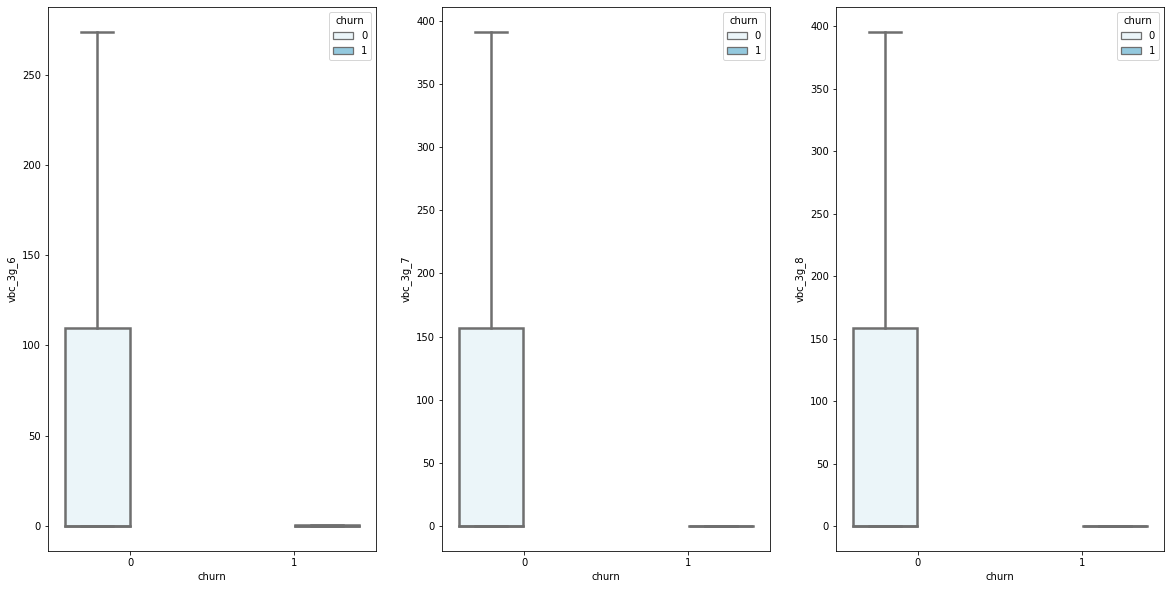

,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,162.370,186.206,180.501,421.204,452.599,432.852
Non Churned,115.097,96.076,40.852,359.705,312.566,211.713


In [266]:
#Check the volumne based cost for 3G
volumn_based_cost_3g = df.columns[df.columns.str.contains('vbc_3g')]

# analyze volume based cost
analyze_col('vbc_3g')

In the 8th month vbc is much lower for churned customers in the 8th month.

In [267]:
#Deriving new column in good phase vbc_3g_good_ph
df['vbc_3g_good_ph'] = (df['vbc_3g_6'] + df['vbc_3g_7'])/2

# drop the original columns
df.drop(['vbc_3g_6','vbc_3g_7'],axis=1,inplace=True)

In [268]:
#Analyzing check sachet subscription for 2G/3G

sachet_2g_3g = df.columns[df.columns.str.contains('sachet_2g|sachet_3g',regex=True)]

print(df.loc[:,sachet_2g_3g].describe())

pd.DataFrame([df.loc[df.churn==0,sachet_2g_3g].mean()
              ,df.loc[df.churn==1,sachet_2g_3g].mean()],index={'Non Churned','Churned'})

        sachet_2g_6   sachet_2g_7   sachet_2g_8   sachet_3g_6   sachet_3g_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean       1.066064      1.214026      1.054865      0.209393      0.227492   
std        2.507197      2.736158      2.535940      0.985674      1.089929   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      0.000000      0.000000   
max       42.000000     48.000000     44.000000     29.000000     35.000000   

        sachet_3g_8  
count  30001.000000  
mean       0.202393  
std        1.100107  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       41.000000  


,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Churned,1.069303,1.243832,1.124383,0.206313,0.228048,0.214550
Non Churned,1.029496,0.877509,0.269971,0.244162,0.221221,0.065137


There is a clear drop in sachet services in 8th month for churned cutsomers as compared to non churned customers.

In [269]:
#Deriving two new derived columns sachet_2g_good_ph and sachet_3g_good_ph

df['sachet_2g_good_ph'] = (df.sachet_2g_6 + df.sachet_2g_7)/2
df['sachet_3g_good_ph'] = (df.sachet_3g_6 + df.sachet_3g_7)/2

# drop the original columns 
df.drop(['sachet_2g_6','sachet_2g_7'
              ,'sachet_3g_6','sachet_3g_7'],axis=1,inplace=True)

In [270]:
#Check the age on n/w for churned & non churned customers
print(df.loc[df.churn==1,'aon'].mean())
print(df.loc[df.churn==0,'aon'].mean())

860.9524784924212
1240.2281204644412


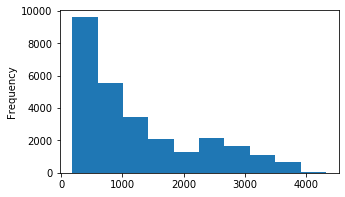

In [271]:
# Checking distribution of Age for non churned customers
plt.figure(figsize=(5,3))
df.loc[df.churn==0,'aon'].plot.hist()
plt.show()

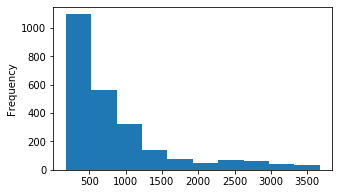

In [272]:
#Checking distribution of Age for churned customers
plt.figure(figsize=(5,3))
df.loc[df.churn==1,'aon'].plot.hist()
plt.show()

Most of the customer who churn have the age of 1500 days or less.

In [273]:
#Check the circle id values
df.circle_id.unique()


array([109], dtype=int64)

In [274]:
#drop this column as it has only one value i.e 109
df.drop('circle_id',inplace=True,axis=1)

#### Dealing with date columns

In [275]:
#extracting the date columns
date_cols = df.columns[df.columns.str.contains('date')]

# convert to datetime
for date_col in list(date_cols):
    df[date_col]= pd.to_datetime(df[date_col])
    
print(df.last_date_of_month_6.dt.day.unique(),df.last_date_of_month_7.dt.day.unique()
      ,df.last_date_of_month_8.dt.day.unique())



[30] [31. nan] [31. nan]


In [276]:
# Lets drop these cols as they do not add much value

df.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],axis=1,inplace=True)

In [277]:
#Extract the day of last recharge
df['day_of_last_rech_6'] =  df.date_of_last_rech_6.dt.day
df['day_of_last_rech_7'] =  df.date_of_last_rech_7.dt.day
df['day_of_last_rech_8'] =  df.date_of_last_rech_8.dt.day

dt_of_last_rech_cols = ['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']

pd.DataFrame([df.loc[df.churn==0,dt_of_last_rech_cols].median()
              ,df.loc[df.churn==1,dt_of_last_rech_cols].median()],index={'Non Churned','Churned'})

,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8
Churned,28.0,29.0,29.0
Non Churned,28.0,27.0,26.0


In [278]:
#Deriving column indicating the shift in day of last recharge

df['day_of_last_rech_shift'] = df.day_of_last_rech_8 -(df.day_of_last_rech_6+df.day_of_last_rech_7)/2

# checking how the shift indicates pattern for Churned and non churn customers
pd.DataFrame([df.loc[df.churn==0,['day_of_last_rech_shift']].median()
              ,df.loc[df.churn==1,['day_of_last_rech_shift']].median()],index={'Non Churned','Churned'})

,day_of_last_rech_shift
Churned,0.5
Non Churned,-2.0


The churned customers have a median negative shift that means the last day of recharge is in the early parts of the month of in the action phase.

In [279]:
#Deleting the columns as we will use the derived columns.

df.drop(['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8'],axis=1,inplace=True)

In [280]:
#extracting the day of last data recharge

df['day_of_last_rech_data_6'] =  df.date_of_last_rech_data_6.dt.day
df['day_of_last_rech_data_7'] =  df.date_of_last_rech_data_7.dt.day
df['day_of_last_rech_data_8'] =  df.date_of_last_rech_data_8.dt.day

dt_of_last_data_rech_cols = ['day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8']

pd.DataFrame([df.loc[df.churn==0,dt_of_last_data_rech_cols].median()
              ,df.loc[df.churn==1,dt_of_last_data_rech_cols].median()],index={'Non Churned','Churned'})

,day_of_last_rech_data_6,day_of_last_rech_data_7,day_of_last_rech_data_8
Churned,22.0,24.0,23.0
Non Churned,22.0,20.0,15.0


The median value of last day of recharge for churned customers in the 8th month is 15. WHich is a clear sign of customer may churn.

In [281]:
#Deriving column indicating the shift in day of last data recharge

df['day_of_last_rech_data_shift'] = df.day_of_last_rech_data_8 -(df.day_of_last_rech_data_6+df.day_of_last_rech_data_7)/2

#checking how the shift indicates pattern for Churned & non churn customers
pd.DataFrame([df.loc[df.churn==0,['day_of_last_rech_data_shift']].median()
              ,df.loc[df.churn==1,['day_of_last_rech_data_shift']].median()],index={'Non Churned','Churned'})

,day_of_last_rech_data_shift
Churned,-0.5
Non Churned,-6.0


There is a significant negative shift in the data recharge in the 8th month. This column will be helpful in our analysis.

In [282]:
#deleting below columns as they are no longer required.
df.drop(['day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8'],axis=1,inplace=True)
df.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'],axis=1,inplace=True)
df.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'],axis=1,inplace=True)

Churn Statistics (mean and standard deviation):
{6: 'arpu_6', 7: 'arpu_7', 8: 'arpu_8'}


<Figure size 1440x720 with 0 Axes>

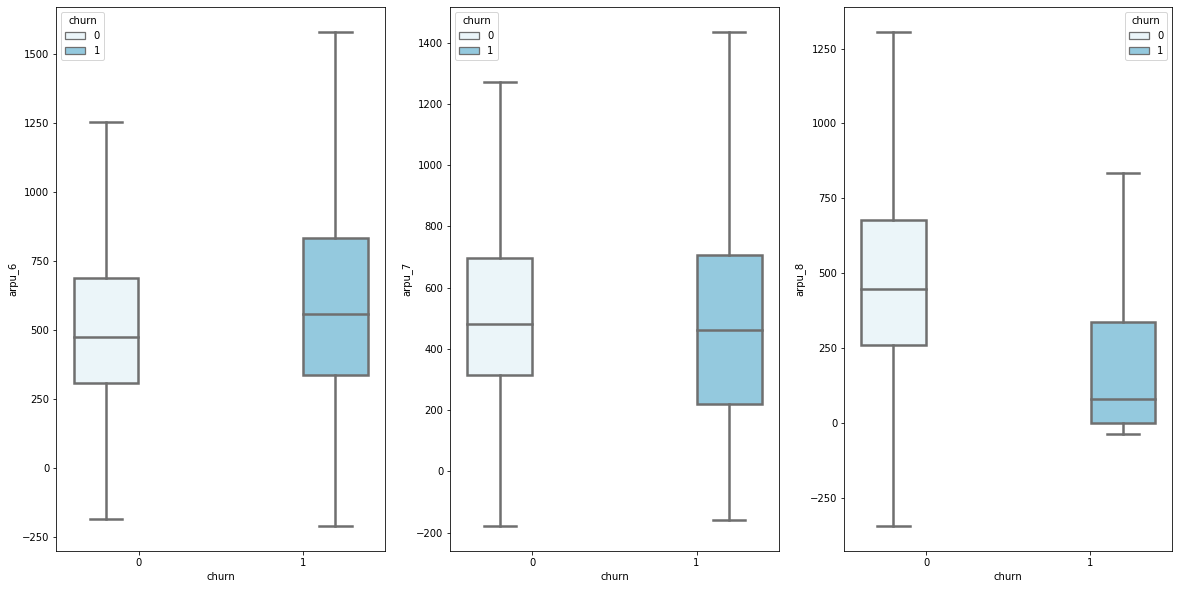

,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,549.220,562.608,532.636,446.851,474.005,503.944
Non Churned,663.158,540.166,237.201,584.538,540.367,386.441


In [283]:
#Analyzing average revenue per user
arpu_cols = df.columns[df.columns.str.contains('arpu_')]

#Analyze arpu
analyze_col('arpu')

As we can see above the average revenue per user also drops in the action phase.


In [284]:
#Deriving new column average revenue per user in good phase.

df['arpu_good_ph'] = (df.arpu_6 + df.arpu_7)/2

#Dropping original columns
df.drop(['arpu_6','arpu_7'],axis=1,inplace=True)

In [285]:
#Lets check the mou columns now and try to derive new feature if possible

mou_cols = df.columns[df.columns.str.contains('mou')]
mou_cols

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_o

In [286]:
#Checking from the mou columns if there are any columns which has standard deviation zero 
#which means it wont add any value and we can drop those columns.

mou_zero_cols = df.loc[:,mou_cols].std()[df.loc[:,mou_cols].std()==0].index.values

mou_zero_cols

array(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype=object)

In [287]:
#Dropping above cols

df.drop(list(mou_zero_cols),axis=1,inplace=True)

In [288]:
#Checking null values in mou cols

mou_cols = df.columns[df.columns.str.contains('mou')]
100*df.loc[:,mou_cols].isnull().sum()/len(df.loc[:,mou_cols])

onnet_mou_6         1.816606
onnet_mou_7         1.789940
onnet_mou_8         3.913203
offnet_mou_6        1.816606
offnet_mou_7        1.789940
offnet_mou_8        3.913203
roam_ic_mou_6       1.816606
roam_ic_mou_7       1.789940
roam_ic_mou_8       3.913203
roam_og_mou_6       1.816606
roam_og_mou_7       1.789940
roam_og_mou_8       3.913203
loc_og_t2t_mou_6    1.816606
loc_og_t2t_mou_7    1.789940
loc_og_t2t_mou_8    3.913203
loc_og_t2m_mou_6    1.816606
loc_og_t2m_mou_7    1.789940
loc_og_t2m_mou_8    3.913203
loc_og_t2f_mou_6    1.816606
loc_og_t2f_mou_7    1.789940
loc_og_t2f_mou_8    3.913203
loc_og_t2c_mou_6    1.816606
loc_og_t2c_mou_7    1.789940
loc_og_t2c_mou_8    3.913203
loc_og_mou_6        1.816606
loc_og_mou_7        1.789940
loc_og_mou_8        3.913203
std_og_t2t_mou_6    1.816606
std_og_t2t_mou_7    1.789940
std_og_t2t_mou_8    3.913203
                      ...   
loc_ic_t2m_mou_6    1.816606
loc_ic_t2m_mou_7    1.789940
loc_ic_t2m_mou_8    3.913203
loc_ic_t2f_mou

In [289]:
#For the missing values in mou calls, it means that customer have not done any recharge that month. 
#We can replace those values with zero.

df.loc[:,mou_cols] = df.loc[:,mou_cols].replace(np.NaN,0)

Lets analyze below sub groups of mou

- offnet: all kinds of calls outside operator network
- onnet: all kinds of call within same operator network
- og: outgoing calls
- ic: incoming calls


In [290]:
#Mou cols for month 6

mou_cols_6 = df.columns[df.columns.str.contains('mou_6')]
mou_cols_6

Index(['onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6',
       'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6',
       'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6',
       'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6',
       'spl_og_mou_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6',
       'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6',
       'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6',
       'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6'],
      dtype='object')

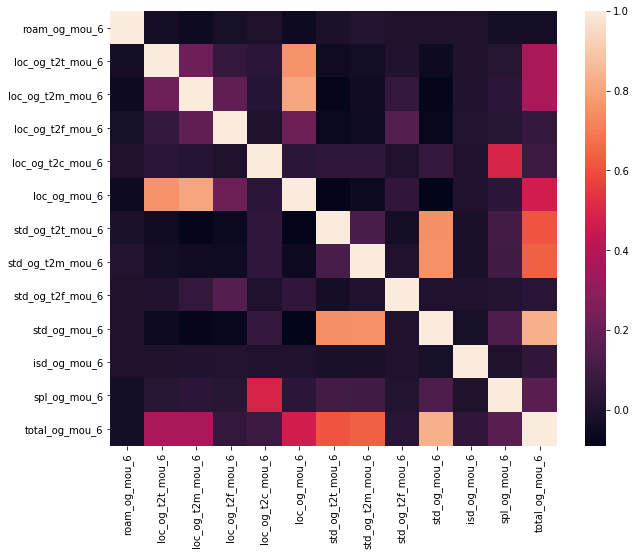

In [291]:
#analyzing outgoing mou variables.
mou_og_cols6 = df.columns[df.columns.str.contains('.*_og_.*mou_6',regex=True)]

# analyzing heatmap among quantitative varibales
plt.figure(figsize=(10, 8))
sns.heatmap(df.loc[:,mou_og_cols6].corr())
plt.show()

#From the above heatmap we can conclude the following

- total_og_mou_6 = loc_og_mou_6+std_og_mou_6+spl_og_mou_6+isd_og_mou_6+ roam_og_mou_6+og_others_6
- loc_og_mou_6 = loc_og_t2m_mou_6+loc_og_t2t_mou_6+loc_og_t2f_mou_6 + loc_og_2tc_mou_6
- std_og_mou_6 = std_og_t2m_mou_6+std_og_t2t_mou_6+std_og_t2f_mou_6 + std_og_2tc_mou_6

In [292]:
#Confirming the above relationship

print(df.loc[7,'total_og_mou_6'],df.loc[7,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6','og_others_6']].sum())
print(df.loc[7,'loc_og_mou_6'],df.loc[7,['loc_og_t2m_mou_6','loc_og_t2t_mou_6','loc_og_t2f_mou_6','loc_og_2tc_mou_6']].sum())
print(df.loc[7,'std_og_mou_6'],df.loc[7,['std_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2f_mou_6','std_og_loc_mou_6']].sum())


487.53 487.52000000000004
422.16 422.15
60.86 60.849999999999994


In [293]:
#SInce we already have variables describing total_og_mou_6, loc_og_mou_6 and std_og_mou_6
#we can drop those columns

total_std_loc_og_cols = df.columns[df.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
df.drop(total_std_loc_og_cols,axis=1,inplace=True)

In [294]:
#Defining good phase derived variables for all og components.
df['spl_og_mou_good_ph'] = (df.spl_og_mou_6 + df.spl_og_mou_7)/2
df['isd_og_mou_good_ph'] = (df.isd_og_mou_6 + df.isd_og_mou_7)/2
df['roam_og_mou_good_ph'] = (df.roam_og_mou_6 + df.roam_og_mou_7)/2
df['std_og_t2m_mou_good_ph'] = (df.std_og_t2m_mou_6 + df.std_og_t2m_mou_7)/2
df['std_og_t2t_mou_good_ph'] = (df.std_og_t2t_mou_6 + df.std_og_t2t_mou_7)/2
df['std_og_t2f_mou_good_ph'] = (df.std_og_t2f_mou_6 + df.std_og_t2f_mou_7)/2

df['loc_og_t2m_mou_good_ph'] = (df.loc_og_t2m_mou_6 + df.loc_og_t2m_mou_7)/2
df['loc_og_t2t_mou_good_ph'] = (df.loc_og_t2t_mou_6 + df.loc_og_t2t_mou_7)/2
df['loc_og_t2f_mou_good_ph'] = (df.loc_og_t2f_mou_6 + df.loc_og_t2f_mou_7)/2
df['loc_og_t2c_mou_good_ph'] = (df.loc_og_t2c_mou_6 + df.loc_og_t2c_mou_7)/2


In [295]:
# dropping the original og mou cols
og_mou_cols = df.columns[df.columns.str.contains('.*_og_.*mou_6|.*_og_.*mou_7',regex=True)]

df.drop(og_mou_cols,axis=1,inplace=True)

In [296]:
#LEts check the same for incoming mou variables

mou_ic_cols6 = df.columns[df.columns.str.contains('.*_ic_.*mou_6',regex=True)]

print(df.loc[7,'total_ic_mou_6'],df.loc[7,['loc_ic_mou_6','roam_ic_mou_6','isd_ic_mou_6','spl_ic_mou_6','std_ic_mou_6']].sum())
print(df.loc[7,'loc_ic_mou_6'],df.loc[7,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','loc_ic_t2c_mou_6']].sum())
print(df.loc[7,'std_ic_mou_6'],df.loc[7,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6','std_ic_t2c_mou_6']].sum())

626.46 626.92
427.88 427.86
180.54 180.51999999999998


We find similar relationship to the og variables. We can delete these columns

In [297]:
#Dropping the cols
total_std_loc_ic_cols = df.columns[df.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
df.drop(total_std_loc_ic_cols,axis=1,inplace=True)

In [298]:
#adding new good phase derive variables for all incoming variables:
df['spl_ic_mou_good_ph'] = (df.spl_ic_mou_6 + df.spl_ic_mou_7)/2
df['isd_ic_mou_good_ph'] = (df.isd_ic_mou_6 + df.isd_ic_mou_7)/2
df['roam_ic_mou_good_ph'] = (df.roam_ic_mou_6 + df.roam_ic_mou_7)/2
df['std_ic_t2m_mou_good_ph'] = (df.std_ic_t2m_mou_6 + df.std_ic_t2m_mou_7)/2
df['std_ic_t2t_mou_good_ph'] = (df.std_ic_t2t_mou_6 + df.std_ic_t2t_mou_7)/2
df['std_ic_t2f_mou_good_ph'] = (df.std_ic_t2f_mou_6 + df.std_ic_t2f_mou_7)/2

df['loc_ic_t2m_mou_good_ph'] = (df.loc_ic_t2m_mou_6 + df.loc_ic_t2m_mou_7)/2
df['loc_ic_t2t_mou_good_ph'] = (df.loc_ic_t2t_mou_6 + df.loc_ic_t2t_mou_7)/2
df['loc_ic_t2f_mou_good_ph'] = (df.loc_ic_t2f_mou_6 + df.loc_ic_t2f_mou_7)/2

In [299]:
#Dropping the original ic cols

ic_cols = df.columns[df.columns.str.contains('.*_ic_.*mou_6|.*_ic_.*mou_7',regex=True)]

df.drop(ic_cols,axis=1,inplace=True)

Churn Statistics (mean and standard deviation):
{6: 'offnet_mou_6', 7: 'offnet_mou_7', 8: 'offnet_mou_8'}


<Figure size 1440x720 with 0 Axes>

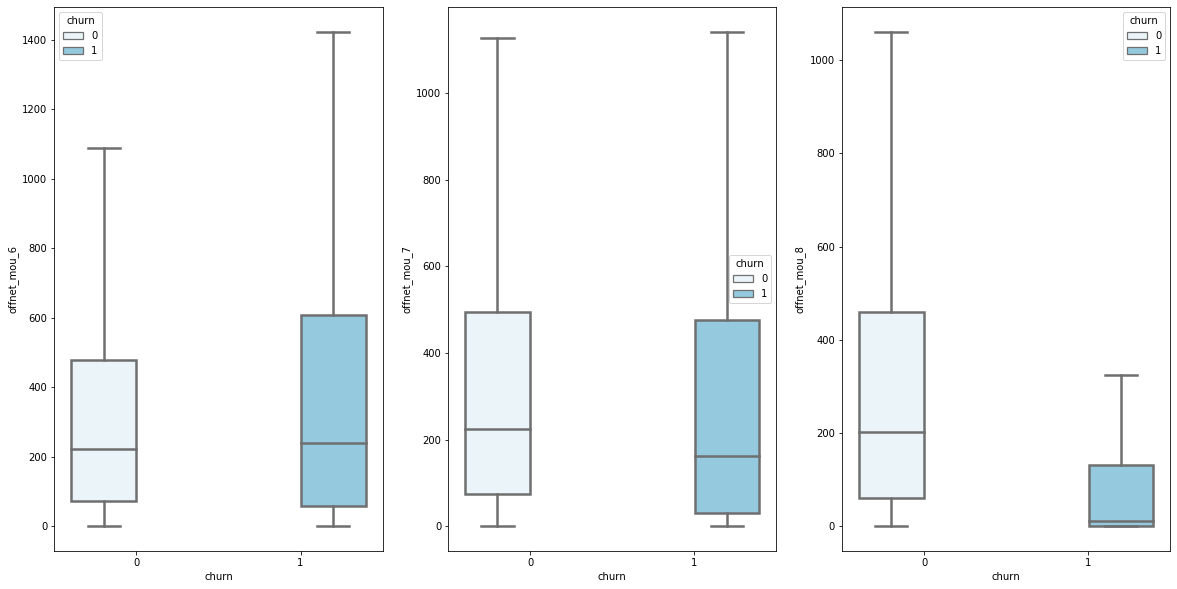

,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,365.046,377.810,352.510,463.187,489.360,490.182
Non Churned,471.331,381.416,138.249,655.048,596.465,317.998


In [300]:
#Lets analyse the offnet variables
offnet_cols = df.columns[df.columns.str.contains('offnet',regex=True)]
    
analyze_col('offnet_mou')

There is a remarkable decrease in offnet mou in the action phase.

In [301]:
#Deriving new column offnet_mou_good_ph
df['offnet_mou_good_ph'] = (df.offnet_mou_6 + df.offnet_mou_7)/2

#dropping the original column
df.drop(['offnet_mou_6','offnet_mou_7'],axis=1,inplace=True)

Churn Statistics (mean and standard deviation):
{6: 'onnet_mou_6', 7: 'onnet_mou_7', 8: 'onnet_mou_8'}


<Figure size 1440x720 with 0 Axes>

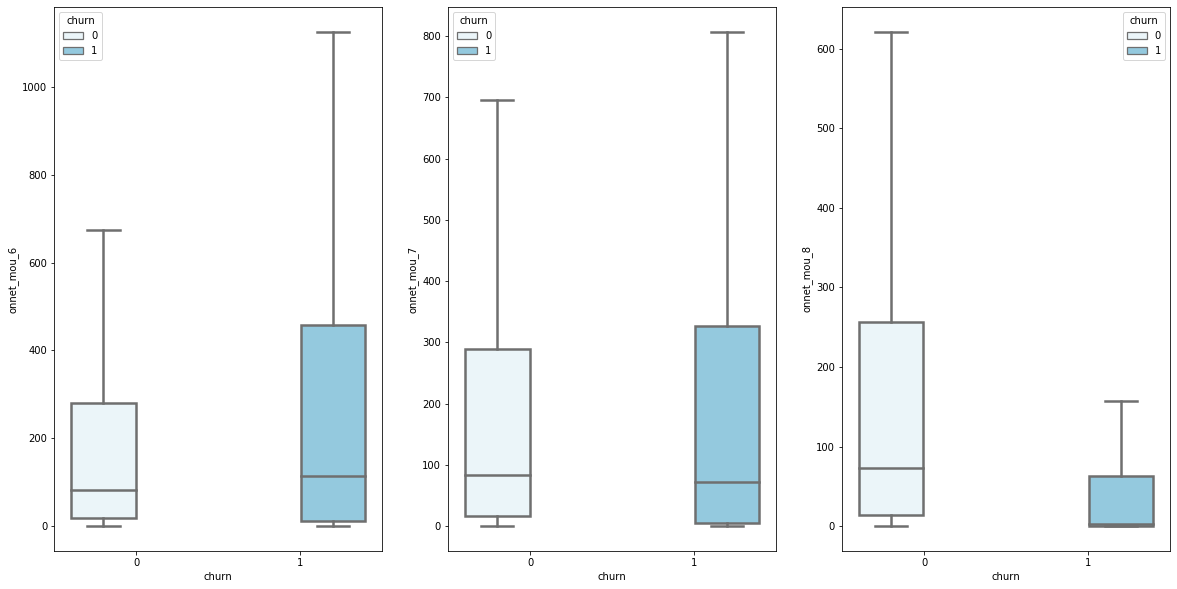

,mean_6,mean_7,mean_8,std_6,std_7,std_8
Churned,251.204,265.641,244.819,442.807,474.160,465.992
Non Churned,369.058,292.408,113.227,608.456,541.016,339.978


In [302]:
#Analyzing mou onnet cols
onnet_cols =  df.columns[df.columns.str.contains('^onnet.*mou',regex=True)]
analyze_col('onnet_mou')

Similiar pattern here too. We can see significant decrease in onnet customers in the 8th month.

In [303]:
#Deriving new feature onnet_mou_good_ph
df['onnet_mou_good_ph'] = (df.onnet_mou_6 + df.onnet_mou_7)/2

#Dropping the original columns.
df.drop(['onnet_mou_6','onnet_mou_7'],axis=1,inplace=True)

We can derive new features for others ic and og cols. 

In [304]:
#Creating og_others_good_ph and ic_others_good_ph
df['og_others_good_ph'] = (df.og_others_6 + df.og_others_7)/2
df['ic_others_good_ph'] = (df.ic_others_6 + df.ic_others_6)/2


#dropping the original columns.
df.drop(['og_others_6','og_others_7','ic_others_6','ic_others_7'],axis=1,inplace=True)

In [305]:
#Checking if there are anymore cols having null values

is_na = df.isnull().sum()/len(df) > 0
100*df.loc[:,is_na].isnull().sum()/len(df.loc[:,is_na])

og_others_8                     3.913203
ic_others_8                     3.913203
night_pck_user_6               44.148528
night_pck_user_7               43.145228
night_pck_user_8               46.825106
fb_user_6                      44.148528
fb_user_7                      43.145228
fb_user_8                      46.825106
day_of_last_rech_shift          2.306590
day_of_last_rech_data_shift    59.904670
og_others_good_ph               2.606580
ic_others_good_ph               1.816606
dtype: float64

In [306]:
#Lets drop cols more than 40% null values as they dont add much value and we already have component features
is_na_40 = df.isnull().sum()/len(df) > 0.40
df.drop(df.columns[is_na_40],axis=1,inplace=True)

In [307]:
#Checking if there are anymore cols having null values

is_na = df.isnull().sum()/len(df) > 0
100*df.loc[:,is_na].isnull().sum()/len(df.loc[:,is_na])

og_others_8               3.913203
ic_others_8               3.913203
day_of_last_rech_shift    2.306590
og_others_good_ph         2.606580
ic_others_good_ph         1.816606
dtype: float64

The percentage for above is really low and we can replace these with zero 

In [308]:
#Replacing remaining null values with zero
df.loc[:,:] = df.loc[:,:].replace(np.NaN,0)

### Model Building

In [309]:
#Assigning variables to X and y
X = df.drop(['churn','mobile_number'],axis=1)
y = df['churn']

In [310]:
#feature list & 8th month feature list
good_phase_features = X.loc[:,X.columns.str.contains('good_ph')]
features_8 = X.loc[:,X.columns.str.contains('_8')]

print(good_phase_features.columns.values)
print(features_8.columns.values)

['total_rech_amt_good_ph' 'total_rech_amt_data_good_ph'
 'max_rech_amt_good_ph' 'last_day_rch_amt_good_ph' 'max_rech_data_good_ph'
 'total_rech_num_good_ph' 'vol_2g_mb_good_ph' 'vol_3g_mb_good_ph'
 'monthly_2g_good_ph' 'monthly_3g_good_ph' 'vbc_3g_good_ph'
 'sachet_2g_good_ph' 'sachet_3g_good_ph' 'arpu_good_ph'
 'spl_og_mou_good_ph' 'isd_og_mou_good_ph' 'roam_og_mou_good_ph'
 'std_og_t2m_mou_good_ph' 'std_og_t2t_mou_good_ph'
 'std_og_t2f_mou_good_ph' 'loc_og_t2m_mou_good_ph'
 'loc_og_t2t_mou_good_ph' 'loc_og_t2f_mou_good_ph'
 'loc_og_t2c_mou_good_ph' 'spl_ic_mou_good_ph' 'isd_ic_mou_good_ph'
 'roam_ic_mou_good_ph' 'std_ic_t2m_mou_good_ph' 'std_ic_t2t_mou_good_ph'
 'std_ic_t2f_mou_good_ph' 'loc_ic_t2m_mou_good_ph'
 'loc_ic_t2t_mou_good_ph' 'loc_ic_t2f_mou_good_ph' 'offnet_mou_good_ph'
 'onnet_mou_good_ph' 'og_others_good_ph' 'ic_others_good_ph']
['arpu_8' 'onnet_mou_8' 'offnet_mou_8' 'roam_ic_mou_8' 'roam_og_mou_8'
 'loc_og_t2t_mou_8' 'loc_og_t2m_mou_8' 'loc_og_t2f_mou_8'
 'loc_og_t2c_m

In [311]:
#Function to calculate difference between 8th month feature & good phase feature
def good_action_ph (i,j):      
    difference = 0.00
    if np.isnan(i) and np.isnan(j):
        difference = np.NAN
    elif np.isnan(j) and ~np.isnan(i):
        difference = i
    elif ~np.isnan(j)and np.isnan(i):
        difference = -j
    else:
        difference = i-j

    return(difference)

In [312]:
#getting copy of X 

X_1 = X.copy()
X_1.columns.values

array(['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'isd_og_mou_8',
       'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'spl_ic_mou_8',
       'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8',
       'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8',
       'max_rech_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8',
       'total_rech_amt_data_8', 'total_rech_amt_good_ph',
       'total_rech_amt_data_good_ph', 'max_rech_amt_good_ph',
       'last_day_rch_amt_good_ph', 'max_rech_data_good_ph',
       'total_rech_num_good_ph', 'vol_2g_mb_good_ph', 'vol_3g_mb_good_ph',
       'monthly_2g_good_ph', 

In [313]:
#Extracting features without any good phase or 8th month indicator.
features_list = set(map(lambda x: x.replace("_good_ph", ""), good_phase_features))
features_list

{'arpu',
 'ic_others',
 'isd_ic_mou',
 'isd_og_mou',
 'last_day_rch_amt',
 'loc_ic_t2f_mou',
 'loc_ic_t2m_mou',
 'loc_ic_t2t_mou',
 'loc_og_t2c_mou',
 'loc_og_t2f_mou',
 'loc_og_t2m_mou',
 'loc_og_t2t_mou',
 'max_rech_amt',
 'max_rech_data',
 'monthly_2g',
 'monthly_3g',
 'offnet_mou',
 'og_others',
 'onnet_mou',
 'roam_ic_mou',
 'roam_og_mou',
 'sachet_2g',
 'sachet_3g',
 'spl_ic_mou',
 'spl_og_mou',
 'std_ic_t2f_mou',
 'std_ic_t2m_mou',
 'std_ic_t2t_mou',
 'std_og_t2f_mou',
 'std_og_t2m_mou',
 'std_og_t2t_mou',
 'total_rech_amt',
 'total_rech_amt_data',
 'total_rech_num',
 'vbc_3g',
 'vol_2g_mb',
 'vol_3g_mb'}

In [314]:
#Deriving features for 8th month
for f in features_list:
    X_1[f+'_act_ph']= np.vectorize(good_action_ph)(X_1[f+'_8'], X_1[f+'_good_ph'])

In [315]:
#Dropping original cols
X_1.drop(features_8,axis=1,inplace=True)

In [316]:
#Standardizing features

from sklearn.preprocessing import StandardScaler
cols = X_1.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_1)
X_scaled = pd.DataFrame(X_1, columns=cols)

In [317]:
#Splitting the data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, train_size=0.7,test_size=0.3,random_state=100)

In [318]:
#function to calculate & print model accuracy metrics.
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score

def Metrics(y_test,y_pred):
    cp = confusion_matrix(y_test,y_pred)
    sensitivity = cp[1,1]/(cp[1,0]+cp[1,1])
    specificity =  cp[0,0]/(cp[0,1]+cp[0,0])
    precision = cp[1,1]/(cp[0,1]+cp[1,1])
    
    #Print model metrics
    print("Confusion Matrix:")
    print(cp)
    print("AUC Score: ", roc_auc_score(y_test,y_pred)) 
    print("Precision: ",precision)
    print("f1 Score: ",f1_score(y_test,y_pred))
    print("Sensitivity: ", sensitivity)
    print("Specificity: ",specificity)

#### Building Logistic Regression Model 

In [319]:
from sklearn.linear_model import LogisticRegression
lsr = LogisticRegression()
lsr.fit(X_train,y_train)

#Predict results on test
y_pred = lsr.predict(X_test)

In [320]:
#checking model evaluation metrics
Metrics(y_test,y_pred)

Confusion Matrix:
[[8149  102]
 [ 523  227]]
AUC Score:  0.6451522643719952
Precision:  0.6899696048632219
f1 Score:  0.4207599629286376
Sensitivity:  0.30266666666666664
Specificity:  0.987637862077324


Since the data has only about 8% of churned customers, the model is biased. Hence very low Sensitivity and AUC score.
We must handle data imbalance.

### Handling Data Imbalance

#### SMOTE

In [321]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(kind = "regular")

# SMOTE sampling the training data
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [322]:
#Logistic regression after SMOTE
lsr = LogisticRegression()
lsr.fit(X_sm,y_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [323]:
#pridicting on test
y_pred = lsr.predict(X_test)
Metrics(y_test,y_pred)

Confusion Matrix:
[[6913 1338]
 [ 125  625]]
AUC Score:  0.8355855855855856
Precision:  0.3183902190524707
f1 Score:  0.46074456321415413
Sensitivity:  0.8333333333333334
Specificity:  0.8378378378378378


#### Majority class under sampling 

In [326]:
#Creating a function to undersample majority class
def MajorityClassUnderSampler(X_train,y_train):
    # Here we create training data frame
    df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)],axis=1)
    
    #Here select the minority class (in our case churn)
    df_train_minority_class  = df_train.loc[df_train.churn == 1,:]
    
    #Here create data frame with majority class samples same as minority class
    df_train_majority_undersampled = pd.concat([df_train_minority_class,df_train.loc[df_train.churn == 0,:].sample(df_train_minority_class.shape[0])])

    return df_train_majority_undersampled

In [327]:
#Creating a majority class undersampled data frame from training data
df_train_mju = MajorityClassUnderSampler(X_train,y_train)

#Extracting features and labels
X_mju = df_train_mju.drop('churn',axis=1)
y_mju = df_train_mju.churn


In [328]:
#After the undersmapling lets take the average of 10 runs to find the avg metrics
sensitivity_avg = 0
specificity_avg = 0
auc_score_avg = 0
precision_avg = 0

for i in range(0,10):
    df_train_mju = MajorityClassUnderSampler(X_train,y_train)
    X_mju = df_train_mju.drop('churn',axis=1)
    y_mju = df_train_mju.churn
    lsr = LogisticRegression()
    lsr.fit(X_mju,y_mju)
    y_pred = lsr.predict(X_test)
    cp = confusion_matrix(y_test,y_pred)
    sensitivity = cp[1,1]/(cp[1,0]+cp[1,1])
    specificity =  cp[0,0]/(cp[0,1]+cp[0,0])
    precision = cp[1,1]/(cp[0,1]+cp[1,1])
    auc_score = roc_auc_score(y_test,y_pred)
    sensitivity_avg = sensitivity_avg + sensitivity
    specificity_avg = specificity_avg+ specificity
    auc_score_avg = auc_score_avg + auc_score
    precision_avg = precision_avg + precision 

In [329]:
#Printing the accuracy score after taking the average
print('AUC Score: ',auc_score_avg/10)
print('Precision: ',precision_avg/10)  
print('Sensitivity: ',sensitivity_avg/10)
print('Specificity: ',specificity_avg/10)

AUC Score:  0.827580826566477
Precision:  0.29342964824097495
Sensitivity:  0.8388
Specificity:  0.8163616531329534


We will consider our mjority caalss under sampled data for further analysis.

### Principal Component Analysis

In [110]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=101)

pca.fit(X_mju)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=101,
  svd_solver='randomized', tol=0.0, whiten=False)

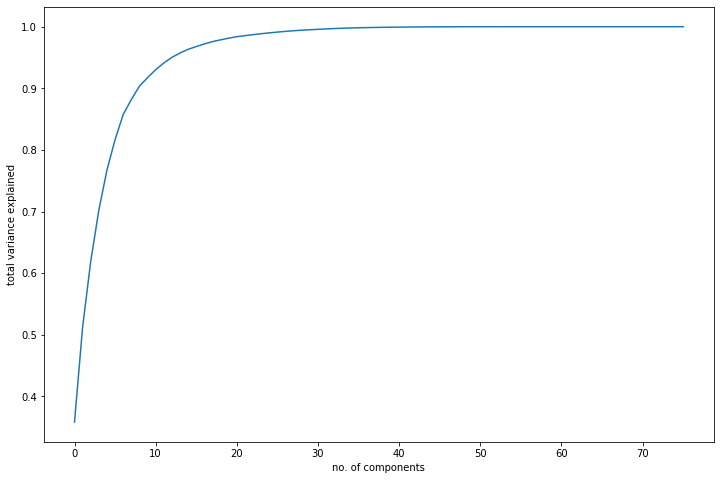

In [111]:
#plotting scree plot to find out the optimal no. of features
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no. of components')
plt.ylabel('total variance explained')
plt.show()

Around 40 features explain more than 95% of variance.

In [112]:
#Using incremental PCA with 40 components

from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=40)

X_train_pca = pca_final.fit_transform(X_mju)

X_train_pca.shape

(3382, 40)

In [113]:
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(9001, 40)

In [114]:
#Fitting the PCA model
lsr_pca = LogisticRegression()
model_pca = lsr_pca.fit(X_train_pca,y_mju)

y_pred = lsr_pca.predict(X_test_pca)

#PRinting the accuracy metrics
Metrics(y_test,y_pred)

Confusion Matrix:
[[6633 1618]
 [ 125  625]]
AUC Score:  0.8186179452995597
Precision:  0.27864467231386536
f1 Score:  0.41764116271299695
Sensitivity:  0.8333333333333334
Specificity:  0.803902557265786


#### Adujusting Probability threshold cut off

In [115]:
#predicted probability on the PCA model
y_pred_prob = lsr_pca.predict_proba(X_test_pca)

#Putting in a data frame
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df = y_pred_prob_df.iloc[:,[1]]

y_test_df = pd.DataFrame(y_test)
y_test_df['ID'] = y_test_df.index

y_pred_prob_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

#Merging into one df
y_pred_final = pd.concat([y_test_df,y_pred_prob_df],axis=1)

In [116]:
#Renaming the column.
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
y_pred_final.head()

,churn,ID,Churn_Prob
0,1,20296,0.627415
1,1,8279,0.526714
2,0,72269,0.035226
3,0,65602,0.300604
4,1,42758,0.887065


In [117]:
#rearranging the columns to make the df easy to interprete
y_pred_final = y_pred_final.reindex_axis(['ID','churn','Churn_Prob'], axis=1)
y_pred_final.head()

,ID,churn,Churn_Prob
0,20296,1,0.627415
1,8279,1,0.526714
2,72269,0,0.035226
3,65602,0,0.300604
4,42758,1,0.887065


In [118]:
#Adding columns with different probability cutoff
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,ID,churn,Churn_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,20296,1,0.627415,1,1,1,1,1,1,1,0,0,0
1,8279,1,0.526714,1,1,1,1,1,1,0,0,0,0
2,72269,0,0.035226,1,0,0,0,0,0,0,0,0,0
3,65602,0,0.300604,1,1,1,1,0,0,0,0,0,0
4,42758,1,0.887065,1,1,1,1,1,1,1,1,1,0


In [120]:
#Calculate accuracy sensitivity & specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['probability','accuracy','specificity','sensitivity','precision'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    precision = cm1[1,1]/(cm1[0,1]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,specificity,sensitivity,precision]
print(cutoff_df)

     probability  accuracy  specificity  sensitivity  precision
0.0          0.0  0.083324     0.000000     1.000000   0.083324
0.1          0.1  0.387846     0.335596     0.962667   0.116377
0.2          0.2  0.527830     0.490365     0.940000   0.143585
0.3          0.3  0.634152     0.609259     0.908000   0.174392
0.4          0.4  0.725253     0.711671     0.874667   0.216145
0.5          0.5  0.806355     0.803903     0.833333   0.278645
0.6          0.6  0.868348     0.876379     0.780000   0.364486
0.7          0.7  0.906233     0.925585     0.693333   0.458554
0.8          0.8  0.922675     0.963156     0.477333   0.540785
0.9          0.9  0.922009     0.989335     0.181333   0.607143


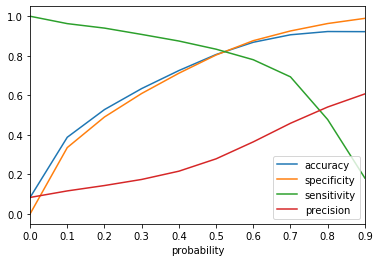

In [121]:
#Plotting the cutoff_df to find the optimum cutoff value
cutoff_df.plot.line(x='probability', y=['accuracy','specificity','sensitivity','precision'])
plt.show()

From the above plot we can see that the optimum cutoff point is little more than 0.5 probability. Lets go with 0.51 and assign churn or non-churn customers.

In [124]:
#Assigning final predicted value 
y_pred_final['final_pred'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.51 else 0)

#Checking the accuracy models.
Metrics(y_pred_final.churn, y_pred_final.final_pred)

Confusion Matrix:
[[6703 1548]
 [ 130  620]]
AUC Score:  0.8195265220377328
Precision:  0.2859778597785978
f1 Score:  0.42494859492803294
Sensitivity:  0.8266666666666667
Specificity:  0.8123863774087989


- The Precision and f1 score is very less. We could improve the sensitivity of the model too.
- Lets try different boosting methods to improve these scores.

#### Boosting with Ada-Boost

In [125]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [126]:
#creating an empty tree
empty_tree = DecisionTreeClassifier(max_depth=2, random_state = 100)

#Estimating optimum number of estimators.
estimators = list(range(40, 150, 10))

auc_scores = []

for n in estimators:
    ABC = AdaBoostClassifier(
    base_estimator=empty_tree, 
    n_estimators = n)
    
    ABC.fit(X_mju, y_mju)
    y_pred = ABC.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    auc_scores.append(score) 

In [127]:
#comparing the auc scores
auc_scores

[0.8311004726699793,
 0.8358278188502404,
 0.8315247444754171,
 0.8335855047872984,
 0.8271007958631278,
 0.829949177877429,
 0.8375855047872984,
 0.8294039510362381,
 0.8317673009332203,
 0.8268583202036116,
 0.8262522522522523]

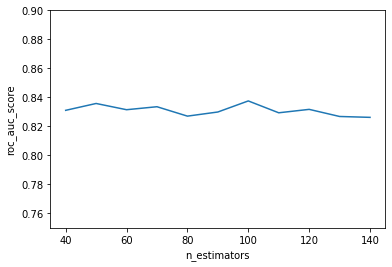

In [128]:
#ploting test scores against no. of estimators
plt.plot(estimators, auc_scores)
plt.xlabel('n_estimators')
plt.ylabel('roc_auc_score')
plt.ylim([0.75, 0.9])
plt.show()

In [129]:
#Model for the best n estimators value.
ABC = AdaBoostClassifier(n_estimators=100,base_estimator=empty_tree)

ABC.fit(X_mju,y_mju)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
          learning_rate=1.0, n_estimators=120, random_state=None)

In [130]:
#Predicting on the test set -
y_pred_abc =  ABC.predict(X_test)

#Printing accuracy scores
Metrics(y_test,y_pred_abc)

Confusion Matrix:
[[6936 1315]
 [ 132  618]]
AUC Score:  0.8323126893709852
Precision:  0.31971029487842734
f1 Score:  0.4606783451360418
Sensitivity:  0.824
Specificity:  0.8406253787419706


- We can see that the scores are improving after the implementation of AdaBoost.

#### Implementation Gradient Boost

In [131]:
from sklearn.ensemble import GradientBoostingClassifier

#Creating parameter grid for learning rate & subsample.
param_grid = {"learning_rate": [0.1,0.2, 0.6, 0.9],
              "subsample": [0.3, 0.6, 0.9]}

#Gradientboost
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)

In [132]:
#Grid search using cross validation
folds = 3
grid_search_GBC = GridSearchCV(GBC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'f1', 
                               return_train_score=True,                         
                               verbose = 1,n_jobs=3)

grid_search_GBC.fit(X_mju, y_mju)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:   46.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'learning_rate': [0.1, 0.2, 0.6, 0.9], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [133]:
#best parameters
grid_search_GBC.best_params_

{'learning_rate': 0.1, 'subsample': 0.9}

In [134]:
#Running gradient boosting with best parameters.
GBC = GradientBoostingClassifier(learning_rate=0.1,subsample=0.9)

#Fitting the model
GBC.fit(X_mju,y_mju)

#Predicting  on the test data
y_pred_abc =  GBC.predict(X_test)


In [135]:
#Checking the scores
Metrics(y_test,y_pred_abc)

Confusion Matrix:
[[7133 1118]
 [ 102  648]]
AUC Score:  0.8642506362865107
Precision:  0.3669309173272933
f1 Score:  0.5151033386327505
Sensitivity:  0.864
Specificity:  0.8645012725730215


- The scores have improved after the implementation of gradient boosting.

#### Building and Ensemble model using decision trees, random forest, linear regression & Linear SVM model.

In [136]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, GridSearchCV

In [137]:
RUN_GRID_SEARCH = True
#RUN_GRID_SEARCH = False

grid_search_best_params_ = {'max_depth': 13,
                             'max_features': 25,
                             'min_samples_leaf': 95,
                             'min_samples_split': 20,
                             'random_state': 10}

def sensitivity_scorer(estimator, X_sensi_scorer, y_sensi_scorer):
     cp = confusion_matrix(y_sensi_scorer, estimator.predict(X_sensi_scorer))
     return cp[1,1]/(cp[1,0]+cp[1,1])

if RUN_GRID_SEARCH:
     parameter_grid = {'max_depth': list(range(1, 20, 1)),
                       'max_features': list(range(10, 20, 2)),
                       'min_samples_leaf': list(range(10, 100, 5)),
                       'min_samples_split': list(range(20, 50, 5)),
                       'max_features': list(range(10, 60, 5)),
                       'random_state': [43]}

     grid_search = GridSearchCV(
         DecisionTreeClassifier(),
         param_grid=parameter_grid,
         scoring=sensitivity_scorer)
     grid_search.fit(X_mju, y_mju)
     grid_search.best_score_, grid_search.best_params_
     grid_search_best_params_ = grid_search.best_params_

In [138]:
#Use the final hyperparmeters obtained from grid search above
print(grid_search_best_params_)

{'max_depth': 1, 'max_features': 15, 'min_samples_leaf': 10, 'min_samples_split': 20, 'random_state': 43}


We get the below params will use the same in further analysis.

{'max_depth': 1, 'max_features': 15, 'min_samples_leaf': 10, 'min_samples_split': 20, 'random_state': 43}


In [140]:
#setting hyper parameters so that we can skip the above block in case we need later as it takes a lot of time
grid_search_best_params_ = {'max_features': 15, 'min_samples_split': 20, 'random_state': 43, 'max_depth': 1, 'min_samples_leaf': 10}

# Build Decision tree using parameters obtained.
dtree=DecisionTreeClassifier(**grid_search_best_params_)

#Fitting the model
dtree.fit(X_mju, y_mju)

#Predicting on the test data and printing the metrics
Metrics(y_test, dtree.predict(X_test))

Confusion Matrix:
[[3360 4891]
 [  70  680]]
AUC Score:  0.6569450167656445
Precision:  0.12206067133369233
f1 Score:  0.21515582977376999
Sensitivity:  0.9066666666666666
Specificity:  0.40722336686462246


In [141]:
#importing linear SVM
from sklearn.svm import LinearSVC

#Building linear SVM model
SVM = LinearSVC()

#Fitting the model
SVM.fit(X_train_pca, y_mju)

#Predicting on the test data and printing the metrics
Metrics(y_test, SVM.predict(X_test_pca))

Confusion Matrix:
[[5142 3109]
 [ 255  495]]
AUC Score:  0.6415985941098049
Precision:  0.13734739178690344
f1 Score:  0.2273771244832338
Sensitivity:  0.66
Specificity:  0.6231971882196098


In [142]:
from sklearn.ensemble import RandomForestClassifier

# build random forest classifier
RFC = RandomForestClassifier(**grid_search_best_params_)#n_estimators=20

#Fitting the model
RFC.fit(X_mju, y_mju)

#Predicting on the test data and printing the metrics
Metrics(y_test, RFC.predict(X_test))

Confusion Matrix:
[[6490 1761]
 [ 188  562]]
AUC Score:  0.767952329010625
Precision:  0.24192854068015499
f1 Score:  0.36576635209892616
Sensitivity:  0.7493333333333333
Specificity:  0.7865713246879166


In [143]:
# build logistic regression model
LSR1 = LogisticRegression()

#Fitting the model
LSR1.fit(X_mju, y_mju)

#Predicting on the test data and printing the metrics
Metrics(y_test, LSR1.predict(X_test))

Confusion Matrix:
[[6744 1507]
 [ 117  633]]
AUC Score:  0.8306777360319961
Precision:  0.2957943925233645
f1 Score:  0.4380622837370242
Sensitivity:  0.844
Specificity:  0.8173554720639923


In [144]:
#Ensembling all the models

ensemble_pred = list(map(lambda x: 1 if (sum(x)>=2) else 0, zip(LSR1.predict(X_test),
                                                          dtree.predict(X_test),            
                                                          RFC.predict(X_test),                                                          
                                                          SVM.predict(X_test_pca))))

#Printing the metrics
Metrics(y_test, ensemble_pred)

Confusion Matrix:
[[5087 3164]
 [  82  668]]
AUC Score:  0.7535989981012403
Precision:  0.174321503131524
f1 Score:  0.29157573112178087
Sensitivity:  0.8906666666666667
Specificity:  0.6165313295358138


#### Deciding the best model:

- From all the models the best prediction model was obtained using ***Gradiant Boost*** with a sensitivity of approximately 86%, a precision of 36% & F1 score of 51% which is much better than our ensemble model.

### Building a simpler model for customer interpretation.

In [343]:
#importing stats model
import statsmodels.api as sm

#Dropping 8th month columns as we are not going to consider them.
#month8_cols =  df.columns[df.columns.str.contains('_8')]
#df = df.drop(month8_cols,axis=1)

X = df.drop(['churn','mobile_number'],axis=1)

y = df['churn']

In [344]:
#Extract columns
cols = X.columns

#Initiating scalar
scaler = StandardScaler()

#Scaling the variables
X_scaled = scaler.fit_transform(X)

#Convert to data frame
X_scaled = pd.DataFrame(X_scaled, columns=cols)

In [345]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, train_size=0.7,test_size=0.3,random_state=100)

#Create majority class undersampled data frame from training data
df_train_mju = MajorityClassUnderSampler(X_train,y_train)

#Extract features & labels
X_mju = df_train_mju.drop('churn',axis=1)
y_mju = df_train_mju.churn


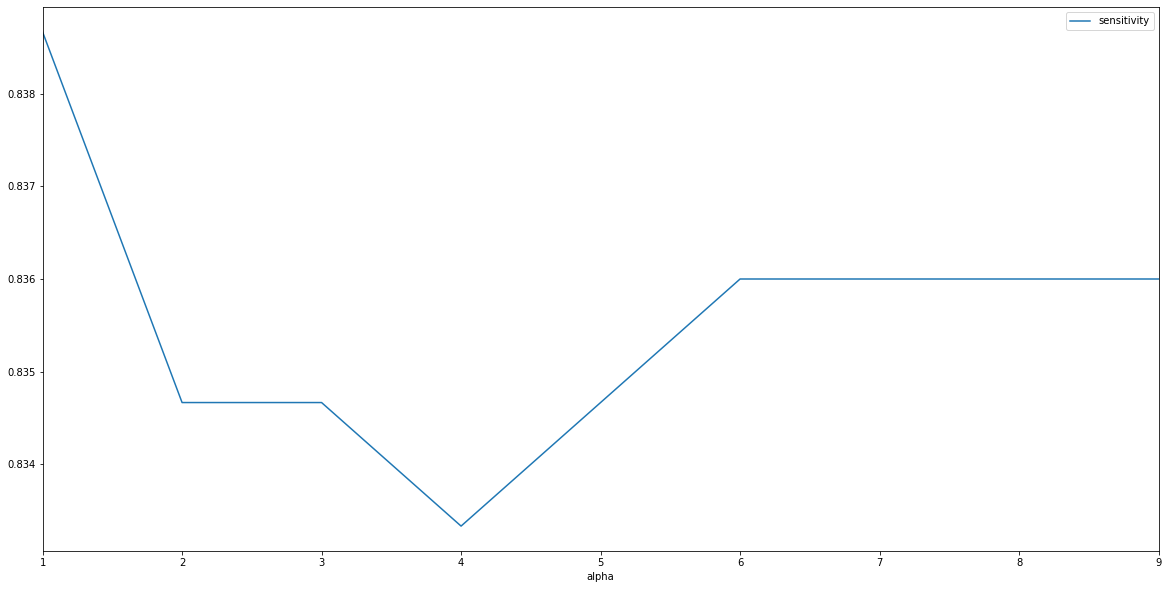

In [346]:
#feature Selection using Lasso Regression
alpha_values=[ 1,2,3,4,5,6,7,8,9]
alpha_sensitivity = []


for alpha in alpha_values:
    lassolr = LogisticRegression(C=alpha, penalty='l1', solver='liblinear')
    lassolr.fit(X_mju, y_mju)
    cp = confusion_matrix(y_test, lassolr.predict(X_test))
    alpha_sensitivity.append({"alpha": alpha, "sensitivity": cp[1,1]/(cp[1,0]+cp[1,1])})

#Plotting the alpha against sentivity to find out the best alpha
pd.DataFrame(alpha_sensitivity).plot.line(x='alpha', y='sensitivity')

Sensitivity is maximized for alpha = 4. 

- **Note** : Please ignore the above plot since the plot changed after running 2 times. 

In [347]:
# run with alpha=0.4 and penalty = 'l1'
lassolr = LogisticRegression(C=4, penalty='l1', solver='liblinear')
lassolr.fit(X_mju, y_mju)
LR_coefs = dict(zip(X_mju.columns, lassolr.coef_[0]))
{k:v for k,v in LR_coefs.items() if v == 0}

{'std_og_t2t_mou_8': 0.0,
 'std_og_t2m_mou_8': 0.0,
 'vol_3g_mb_good_ph': 0.0,
 'loc_og_t2m_mou_good_ph': 0.0,
 'onnet_mou_good_ph': 0.0}

In [348]:
#We will create the model now and eliminate features comparing p-values and VIF by running the model iteratively  
#Function to test model, print metrics, VIF score & can drop columns -
def test_model(x_train, x_test, y_train, y_test, cols_to_drop = None):
    cols_to_drop = cols_to_drop or []
    x_train = x_train.drop(cols_to_drop, axis=1)
    x_test = x_test.drop(cols_to_drop, axis=1)
    lr = LogisticRegression(C=4.0, penalty='l1', solver='liblinear')
    lr.fit(x_train, y_train)
    print("Scoring on TEST {}, TRAIN {}".format(lr.score(x_test,y_test), lr.score(x_train,y_train)))
    Metrics(y_test,lr.predict(x_test))
    x_train = sm.add_constant(x_train)
    stat_model = sm.Logit(y_train, x_train).fit_regularized(method='l1')
    print(stat_model.summary())
    # calculate VIF
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    for i, var in enumerate(x_train.columns):
        rsq = sm.OLS(x_train[var], x_train.drop([var], axis=1)).fit().rsquared
        vif = round( 1 / (1 - rsq + 0.00000000001), 2)
        vif_df.loc[i] = [var, vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [349]:
# run model on majority undersampled training data
test_model(X_mju, X_test, y_mju, y_test)

Scoring on TEST 0.8186868125763804, TRAIN 0.8290952099349498
Confusion Matrix:
[[6744 1507]
 [ 125  625]]
AUC Score:  0.8253444026986629
Precision:  0.29315196998123827
f1 Score:  0.43372657876474674
Sensitivity:  0.8333333333333334
Specificity:  0.8173554720639923
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4190027861917193
            Iterations: 429
            Function evaluations: 429
            Gradient evaluations: 429
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 3382
Model:                          Logit   Df Residuals:                     3305
Method:                           MLE   Df Model:                           76
Date:                Mon, 16 Dec 2019   Pseudo R-squ.:                  0.3955
Time:                        20:36:01   Log-Likelihood:                -1417.1
converged:                       True   LL-Nul

,Var,Vif
73,offnet_mou_good_ph,7332.35
74,onnet_mou_good_ph,6708.16
57,std_og_t2m_mou_good_ph,5819.00
58,std_og_t2t_mou_good_ph,5670.38
2,onnet_mou_8,4590.79
3,offnet_mou_8,4329.26
10,std_og_t2t_mou_8,3587.32
11,std_og_t2m_mou_8,2721.55
60,loc_og_t2m_mou_good_ph,1609.71
7,loc_og_t2m_mou_8,1173.07


In [338]:
#By reterating the model we found that below cols must be deleted on the basis of high p-value and VIF

cols_to_drop=["onnet_mou_8", "std_og_t2m_mou_8", "onnet_mou_good_ph",
       "offnet_mou_good_ph", "roam_ic_mou_good_ph", "loc_og_t2m_mou_good_ph",
      "og_others_8", "total_rech_amt_good_ph", "total_rech_amt_8", "isd_ic_mou_good_ph",
      "arpu_8", "vol_3g_mb_8", "loc_og_t2f_mou_good_ph", "isd_og_mou_8",
      "loc_ic_t2f_mou_good_ph", "spl_og_mou_good_ph", "std_ic_t2m_mou_good_ph",
      "std_og_t2f_mou_good_ph", "total_rech_amt_data_good_ph", "max_rech_data_good_ph",
      "std_ic_t2f_mou_good_ph", "loc_og_t2f_mou_8", "vbc_3g_good_ph", "isd_og_mou_good_ph",
      "total_rech_amt_data_8", "max_rech_amt_good_ph", "total_rech_num_good_ph",
      "sachet_2g_good_ph", "ic_others_8", "std_ic_t2f_mou_8", "og_others_good_ph",
      "ic_others_good_ph", "roam_ic_mou_8", "monthly_3g_good_ph", "loc_ic_t2m_mou_8",
      "loc_ic_t2m_mou_good_ph", "isd_ic_mou_8", "loc_og_t2c_mou_good_ph", "last_day_rch_amt_good_ph",
      "std_og_t2f_mou_8", "sachet_3g_good_ph", "sachet_3g_8", "std_og_t2t_mou_good_ph",
      "spl_ic_mou_good_ph", "loc_og_t2c_mou_8", "spl_og_mou_8", "vbc_3g_8",
      "vol_3g_mb_good_ph", "roam_og_mou_good_ph", "monthly_2g_8", "monthly_3g_8",
      "loc_og_t2t_mou_good_ph", "loc_og_t2t_mou_8", "max_rech_amt_8", "spl_ic_mou_8",
      "std_ic_t2t_mou_good_ph", "std_ic_t2m_mou_8", "std_ic_t2t_mou_8","std_og_t2m_mou_good_ph"]

In [350]:
# run with columns to be dropped to check the final p-values and VIF
test_model(X_mju, X_test, y_mju, y_test, cols_to_drop=cols_to_drop)

Scoring on TEST 0.8073547383624041, TRAIN 0.8137196924896511
Confusion Matrix:
[[6651 1600]
 [ 134  616]]
AUC Score:  0.8137087221750899
Precision:  0.2779783393501805
f1 Score:  0.4153742414025624
Sensitivity:  0.8213333333333334
Specificity:  0.8060841110168464
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.44528236606016564
            Iterations: 78
            Function evaluations: 79
            Gradient evaluations: 78
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 3382
Model:                          Logit   Df Residuals:                     3364
Method:                           MLE   Df Model:                           17
Date:                Mon, 16 Dec 2019   Pseudo R-squ.:                  0.3576
Time:                        20:36:12   Log-Likelihood:                -1505.9
converged:                       True   LL-Null:  

,Var,Vif
1,offnet_mou_8,1.82
3,loc_og_t2m_mou_8,1.73
7,total_rech_num_8,1.67
5,loc_ic_t2t_mou_8,1.65
17,loc_ic_t2t_mou_good_ph,1.58
10,vol_2g_mb_8,1.49
13,vol_2g_mb_good_ph,1.48
11,sachet_2g_8,1.35
16,arpu_good_ph,1.32
14,monthly_2g_good_ph,1.28


### Suggestion to Customer

##### Below features are important and they decide whether the customer will churn or not.

- offnet_mou_8
-	loc_og_t2m_mou_8
-	total_rech_num_8
-	loc_ic_t2t_mou_8
-	loc_ic_t2t_mou_good_ph
-	vol_2g_mb_8
-	vol_2g_mb_good_ph
-	sachet_2g_8
-	arpu_good_ph
-	monthly_2g_good_ph
-	last_day_rch_amt_8	
-	std_og_t2t_mou_8	
-	roam_og_mou_8	
-	max_rech_data_8	
-	loc_ic_t2f_mou_8	
-	aon	
-	day_of_last_rech_shift

Here the model Indicates that the good phase & the action phase parameters have comparative impact on customers churning. There is a higher chance of churn if any good phase indicator is high in range and if there is a drop in any action phase parameter value. 

In [353]:
# Analyzing volume of 2g and 3g usage
cols_3g_2g = df.columns[df.columns.str.contains('vol_2g_mb|vol_3g_mb',regex=True)]

# let's check the mean variation in total recharge numbers for churned and non churned customers
pd.DataFrame([df.loc[df.churn==0,cols_3g_2g].mean()
              ,df.loc[df.churn==1,cols_3g_2g].mean()],index={'Non Churned','Churned'})

,vol_2g_mb_8,vol_3g_mb_8,vol_2g_mb_good_ph,vol_3g_mb_good_ph
Churned,113.243187,374.884935,128.029971,366.686811
Non Churned,23.152745,87.399685,100.742509,250.429226


Apart from the above model based features we have also noticed in EDA that the % of churn is higher for 2G usage as compared to 3G usage suggesting that some users may be migrating to other operators due to availability of better 3G network. Also, in some cases there is a small increase in calls to call centre in 7th month followed by drop in 8th month, which indicates that customers might be calling for some issues based on which they might have decided to switch to a better service provider.

#### Recommendations:


- The company should improve Network coverage for 2G in places where 3G is not avilable.
- Reduced roaming charges as it is one of the major reasons for pre-paid customers to look for local operators while on roaming.
- Customized pre-paid plan offers: Continuous monitoring of behavioural signs listed above in action phase to offer customized per-paid plans to customers, eg : Plans like extra talktime minutes for local and same operator calls
- Privilege Customer offers: for customer who have been a part of the family since long like extra benefits which will further more strengthen the bond
